# Age & Gender Classifier using Deep CNNs  - 

**Dataset : UTKFace**

### Libraries Importing

In [1]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### Drive Mounting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Loading

In [117]:
dataset_folder_name = '/content/drive/My Drive/ECE_539_Project/UTKFace'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 98

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    "gender_id": {
        0: 'male',
        1: 'female'
    },
    #This code chunks needs to be changed based on the 5 or 7 age groups
    "age_group_id":{
        0: "0-9",
        1: "10-19",
        2: "20-24",
        3: "25-29",
        4: "30-39",
        5: "40-59",
        6: "60+"
    }

}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)
#This line of code is newly added
# dataset_dict['age_group_alias'] = dict((a, i) for i, a in dataset_dict['age_group_id'].items())        # (Age_group: id)

The function below will be used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the fields (age, gender and sex) of our records.

In [118]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [119]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...


### Data Analysis & Visualization (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23705 non-null  float64
 1   gender  23705 non-null  object 
 2   race    23705 non-null  object 
 3   file    23705 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.0+ KB


In [7]:
df.head()

,age,gender,race,file
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...


## Data Generator

We will get train_idx, valid_idx, test_idx

In [120]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

Convert alias to id

In [121]:
df

,age,gender,race,file
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
...,...,...,...,...
23703,1.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...
23704,1.0,male,white,/content/drive/My Drive/ECE_539_Project/UTKFac...
23705,1.0,female,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...
23706,1.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...


In [122]:
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])
df["age_group_id"] = None
df

,age,gender,race,file,gender_id,race_id,age_group_id
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,None
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,None
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,None
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,None
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,None
...,...,...,...,...,...,...,...
23703,1.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,None
23704,1.0,male,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,0,None
23705,1.0,female,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,2,None
23706,1.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,None


In [123]:
# Mannually assign the age_group_id to each image base on its age
df["age_group_id"].mask(df["age"] > 0, 0, inplace=True)
df["age_group_id"].mask(df["age"] > 9, 1, inplace=True)
df["age_group_id"].mask(df["age"] > 19, 2, inplace=True)
df["age_group_id"].mask(df["age"] > 24, 3, inplace=True)
df["age_group_id"].mask(df["age"] > 29, 4, inplace=True)
df["age_group_id"].mask(df["age"] > 39, 5, inplace=True)
df["age_group_id"].mask(df["age"] > 59, 6, inplace=True)

In [124]:
df

,age,gender,race,file,gender_id,race_id,age_group_id
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,5
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
...,...,...,...,...,...,...,...
23703,1.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,0
23704,1.0,male,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,0,0
23705,1.0,female,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,2,0
23706,1.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,0


Perform some minor preprocessing on the image before inputting into the network.

In [125]:
def preprocess_image(img_path):
    
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im

Generate a batch with images when training/validating our model.

In [126]:
def generate_images(image_idx, is_training, batch_size=16):  
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age_group']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,7))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
                
        if not is_training:
            break

## Results

In [127]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import ImageOps
from PIL import Image

def loadImage(filepath):
    im = Image.open(filepath)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    im = np.expand_dims(im, axis = 0)
    
    im = tf.image.rgb_to_grayscale(im)
    # im.numpy()
    
    return im

In [128]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])
        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes() 

In [129]:
test_idx

array([14405, 18955,  5886, ...,  4289, 18193, 13302])

In [130]:
df.head()

,age,gender,race,file,gender_id,race_id,age_group_id
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,2,5
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,3,5


In [131]:
test_df = df.iloc[test_idx]
test_df

,age,gender,race,file,gender_id,race_id,age_group_id
14406,15.0,female,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,0,1
18958,17.0,male,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,0,1
5887,26.0,male,black,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,1,3
812,73.0,female,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,0,6
13938,32.0,female,black,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,1,4
...,...,...,...,...,...,...,...
811,73.0,female,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,0,6
15049,35.0,female,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,0,4
4290,27.0,female,black,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,1,3
18196,6.0,female,others,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,4,0


In [132]:
#Check the number of test images in each age_group_id
np.unique(test_df["age_group_id"],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 array([579, 333, 485, 978, 967, 867, 532]))

In [133]:
#Check the number of test images in each gender_id
np.unique(test_df["gender_id"],return_counts=True)

(array([0, 1]), array([2486, 2255]))

In [145]:
#This method is used for making predictions using the model based on 5 age groups
cnn_model = load_model('/content/drive/My Drive/ECE_539_Project/model/midterm/grey_age7_weight_drop02_mod.h5')
def age7_predict(img_path, model):
  picture = img_path
  im = loadImage(picture)
  age_pred = cnn_model.predict(im)
  age_pred = age_pred.argmax(axis = -1)[0]
  return age_pred

In [146]:
img_path = df.iloc[1,:]["file"]
im = loadImage(img_path)
cnn_model.predict(im)

array([[1.0677212e-04, 1.4791389e-04, 7.2332047e-04, 2.0190524e-03,
        1.7293971e-02, 5.5778354e-01, 4.2192543e-01]], dtype=float32)

In [148]:
import time
# For demo
img_path = df.iloc[1,:]["file"]
# model_path = "/content/drive/My Drive/ECE_539_Project/model/midterm/grey_age5_drop02_mod.h5"
age_group_pred = age7_predict(img_path, cnn_model)
print(age_group_pred)

5


In [137]:
test_df.head()

,age,gender,race,file,gender_id,race_id,age_group_id
14406,15.0,female,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,0,1
18958,17.0,male,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,0,1
5887,26.0,male,black,/content/drive/My Drive/ECE_539_Project/UTKFac...,0,1,3
812,73.0,female,white,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,0,6
13938,32.0,female,black,/content/drive/My Drive/ECE_539_Project/UTKFac...,1,1,4


In [151]:
file_paths = test_df["file"]
true_age_group = test_df["age_group_id"]

In [152]:
from tqdm import tqdm
# Making the age_group  based on the path of each image
predicted_age_group = []
for file in tqdm(file_paths):
  age_group_pred = age7_predict(file, cnn_model)
  predicted_age_group.append(age_group_pred)

100%|██████████| 4741/4741 [20:24<00:00,  3.87it/s]


In [171]:
# The Accuracy of Age-Group Clssification
np.mean(age_group_pred != true_age_group)

0.7937144062434086

In [165]:
from sklearn.metrics import r2_score
#Calculate the R2 score of age_group and gender prediction using the model with 5 age groups
print('R2 score for age_group classification: ', r2_score(true_age_group, predicted_age_group))

R2 score for age_group classification:  0.7819640661539173


In [166]:
from sklearn.metrics import f1_score 
#Calculate the F1 score of age_group and gender prediction using the model with 5 age groups
print('F1 score for age_group classification: ', f1_score(list(true_age_group), predicted_age_group, labels=[0,1,2,3,4,5,6], average="weighted"))

F1 score for age_group classification:  0.6491559389046109


In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Generate the Confusion Matrix of age_group and gender prediction using the model with 5 age groups
print("Confusion Matrix for age_group Prediction")
cfm_age_group = confusion_matrix(list(true_age_group), predicted_age_group, labels=[0,1,2,3,4,5,6])
print(cfm_age_group)

Confusion Matrix for age_group Prediction
[[550  20   4   1   2   1   1]
 [ 45 267  12   7   2   0   0]
 [  2  82 319  59  17   6   0]
 [  2  49 258 473 150  43   3]
 [  3  38  98 212 504 103   9]
 [  1  11  12  49 179 534  81]
 [  1   0   2   4  10  77 438]]


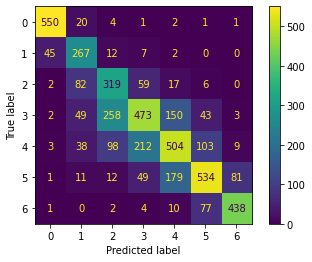

In [168]:
# Visualize the Confusion Matrix of age_group classification
cmd = ConfusionMatrixDisplay(cfm_age_group, display_labels=[0,1,2,3,4,5,6])
cmd.plot()

In [ ]:
from sklearn import metrics
#TODO future task - multiclass ROC curve
#create ROC curve for age_group prediction
# fpr, tpr, _ = metrics.roc_curve(list(true_age_group), predicted_age_group)
# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()